In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import zscore
from presidio.analysis import WaveRedcapDataset

from sklearn.cluster import KMeans
from sklearn.feature_selection import mutual_info_classif, f_classif, f_regression

from joblib import dump, load

%matplotlib inline

SRC_DATA_DIR = './source_data'
PR01_PROVC_SCORES_FN = 'StageII-PR01_Provocation_Feats_Scores.csv'
PR01_STAGEI_CLUSTER_MODEL_FN = 'StageI-PR01_Symptom_State_Clusters.joblib'

# Define Feature Sets

In [2]:
agm = ['Amyg1 - Amyg2_gamma',  'Amyg3 - Amyg4_gamma']

# Composite Dataset

In [4]:
dfc = pd.read_csv(os.path.join(SRC_DATA_DIR, PR01_PROVC_SCORES_FN))
dfc = dfc.set_index(pd.to_datetime(dfc['time for scale']))

start = pd.to_datetime('2020-04-01')
end = pd.to_datetime('2020-8-13')
sel_dfc = dfc[(dfc.index >= start) & (dfc.index < end)]

# Load StageI Symptom Cluster Model

In [5]:
# Load the KMeans model
kmeans = load(os.path.join(SRC_DATA_DIR, PR01_STAGEI_CLUSTER_MODEL_FN))

/home/pmd/Presidio/.env/pres/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator KMeans from version 0.23.2 when using version 0.23.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


# Predict StageII symptom clusters based on StageI model

<ipython-input-6-dab17fc83c52>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sel_dfc['cluster'] = kmeans.predict(sel_dfc[['anxiety', 'depression']])
/home/pmd/Presidio/.env/pres/lib/python3.8/site-packages/pandas/core/generic.py:6746: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


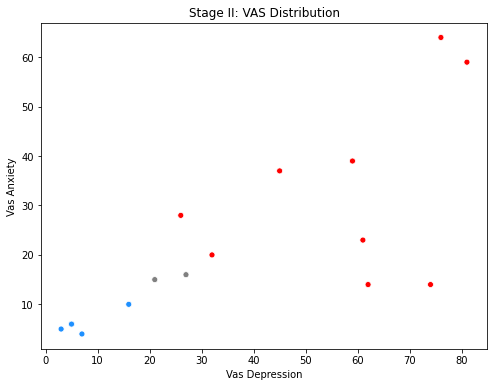

In [6]:
sel_dfc['cluster'] = kmeans.predict(sel_dfc[['anxiety', 'depression']])
cluster_means = sel_dfc.groupby('cluster').apply(lambda g: g[['anxiety', 'depression']].mean(axis=1).mean())\
                                       .to_frame(name='means')\
                                       .sort_values('means')
sel_dfc.cluster.replace({**{cluster_means.index[0]: 0, cluster_means.index[1]: 1},
                         **{c: 2 for c in cluster_means.index[2:]}},
                         inplace=True)

# Scatter Distribution
fig, ax = plt.subplots(figsize=(8, 6))
sns.scatterplot(x='depression', y='anxiety', hue=sel_dfc.cluster, data=sel_dfc, ax=ax, 
                palette=['dodgerblue', 'gray', 'red'], legend=None);

plt.xlabel('Vas Depression')
plt.ylabel('Vas Anxiety')
plt.title('Stage II: VAS Distribution')
plt.show()

## HAMD-6

/home/pmd/Presidio/.env/pres/lib/python3.8/site-packages/scipy/stats/stats.py:1534: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


                            OLS Regression Results                            
Dep. Variable:                   hamd   R-squared:                       0.725
Model:                            OLS   Adj. R-squared:                  0.679
Method:                 Least Squares   F-statistic:                     15.84
Date:                Tue, 13 Jul 2021   Prob (F-statistic):           0.000430
Time:                        21:21:34   Log-Likelihood:                -39.262
No. Observations:                  15   AIC:                             84.52
Df Residuals:                      12   BIC:                             86.65
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   7.0000    

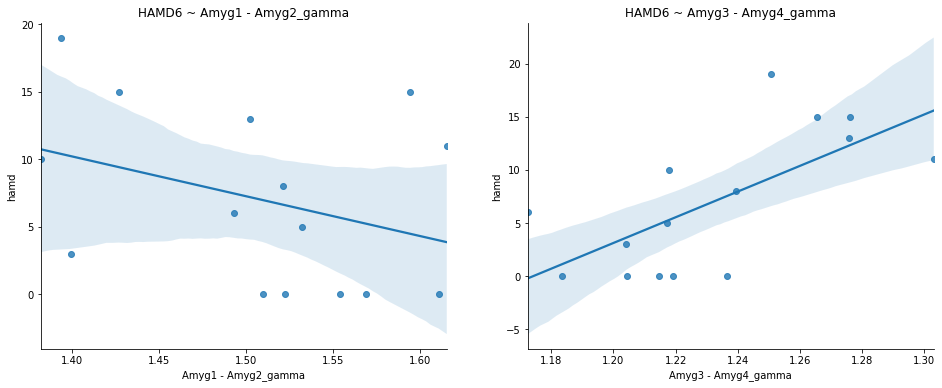

In [7]:
feat = agm
cols = ['hamd'] + feat
xf = sel_dfc[cols].dropna()

X = xf[feat].apply(zscore)
X = sm.add_constant(X)
y = xf['hamd']

lm = sm.OLS(y, X)
res = lm.fit()
print(res.summary())

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
sns.regplot(x=feat[0], y='hamd', 
            data=xf[xf.index.to_series().between(start, end)], ax=ax[0])

ax[0].set_title('HAMD6 ~ {}'.format(feat[0]))

sns.regplot(x=feat[1], y='hamd', 
            data=xf[xf.index.to_series().between(start, end)], ax=ax[1])

ax[1].set_title('HAMD6 ~ {}'.format(feat[1]))
sns.despine()